# Binary Classification of Fake or Real News


Using kaggle's dataset of "Fake and real news dataset", taken from ISOT News Dataset (https://www.uvic.ca/ecs/ece/isot/datasets/fake-news/index.php), we are trying to classify the authenticity of news recorded since 2015 to 2018. 

This dataset was scraped through reuters.com (real news) and politifact.com (fake news) by University of Victoria.

We are using various methods of tokenization and machine learning algorithms to show which algorithms can give the most satisfying result to classify fake or real news.

1. Data preparation
2. Visualization
3. Creating models
- Using tf-idf
    * SVM
    * Decision Tree
    * Random Forest
    * XGBoost
- Using GloVe
    * LSTM
- Using BERT
    * BERT Transformer (pre-trained)




The division of responsibility is as follow,

* Niko is the captain of the team who is responsible for all the data preparation and visualization,

* Wesley is responsible for creating model using TF-IDF

* Vanessa is responsible for creating model using GloVe, and

* John is responsible for creating model using BERT.

Although each of our member has their own responsibilty, we often exchange suggestion and always ask one another if there is any confusion.

``Importing packages``

In [1]:
#!pip install nltk
#!pip install plotly
#!pip install wordcloud
#!pip install tensorflow
#!pip install xgboost
#!pip install datasets
#!pip install transformers[torch]


In [2]:
import os
import pandas as pd
import numpy as np
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, fbeta_score, roc_auc_score,roc_curve,auc

## Data Preparation

This data is prepared by Niko while considering the usage of the data on every model/method we are preparing

``Importing our datasets``

In [3]:
path = 'dataset'

fake = pd.read_csv(os.path.join(path, 'Fake.csv'))
real = pd.read_csv(os.path.join(path, 'True.csv'))

In [4]:
real.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017

We noticed that the first 5 texts of real news have "(Reuters)" and a city name in front of it.

In [5]:
fake.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017

However, this is not the case for fake news. Let's find out how many of real news contain "(Reuters)" tag in it.

In [6]:
print("Real news with 'Reuters': " + str(real.text.str.contains("\(Reuters\) - ").sum()) +"/" + str(real.shape[0]) + ", " + str(real.text.str.contains("\(Reuters\) -").mean()*100)+"%")
print("Fake news with 'Reuters': " + str(fake.text.str.contains("\(Reuters\) - ").sum()) +"/" + str(fake.shape[0]) + ", " + str(fake.text.str.contains("\(Reuters\) -").mean()*100)+"%")

Real news with 'Reuters': 21246/21417, 99.20156884717748%
Fake news with 'Reuters': 0/23481, 0.0%


This can be bad for our machine learning model, as our model can be biased towards the "(Reuters)" word --> if it contains "(Reuters)", predict real news.

Let's see what happens if we predict False (real news) when the text contains "(Reuters)"


``Combining real and fake news data to 1 DataFrame``

In [7]:
fake_with_label = fake.assign(is_fake = 1)
real_with_label = real.assign(is_fake = 0)

data = pd.concat([real_with_label,fake_with_label],axis=0,ignore_index=True) 

In [8]:
no_reuters = ~data.text.str.contains("\(Reuters\) - ")

Accuracy score: 99.61913670987572%

Confusion matrix: 


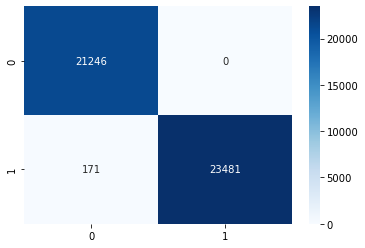

In [9]:
cf_matrix = confusion_matrix(no_reuters, data['is_fake'])

sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt = "d")

print("Accuracy score: "+str(accuracy_score(no_reuters, data['is_fake'])*100) + "%")
print("\nConfusion matrix: ")

We can obtain 99.6% accuracy with only that condition. Therefore, we need to delete "(Reuters)" if it appears in the first 5 words of the text, delete it and the city name preceding it.

To do this, we are using regex, which is '.\*\\(Reuters\) - ', meaning everything before and the word '(Reuters) - '. The function below deletes the words according to the regex in data['text'].

``Removing the words``

In [10]:
# data = data.replace(to_replace = r'.*\(Reuters\) - ', value = '', regex = True)

# Exported to save time running the program
# data.to_csv(os.path.join(path,"data.csv"))

# Load exported file
data = pd.read_csv(os.path.join(path,"data.csv"))


data.head()

Unnamed: 0                                              title  \
0           0  As U.S. budget fight looms, Republicans flip t...   
1           1  U.S. military to accept transgender recruits o...   
2           2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3           3  FBI Russia probe helped by Australian diplomat...   
4           4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  The head of a conservative Republican faction ...  politicsNews   
1  Transgender people will be allowed for the fir...  politicsNews   
2  The special counsel investigation of links bet...  politicsNews   
3  Trump campaign adviser George Papadopoulos tol...  politicsNews   
4  President Donald Trump called on the U.S. Post...  politicsNews   

                 date  is_fake  
0  December 31, 2017         0  
1  December 29, 2017         0  
2  December 31, 2017         0  
3  December 30, 2017         0  
4  December 29, 2017         0

Great! We successfully removed a huge exploit to our model. 

Another problem that usually happens is empty/null values in our dataset. Let's check if there are any.

In [11]:
data = data.replace(to_replace = r'U.S.', value = 'U.S.A.', regex = True)
data.head()

Unnamed: 0                                              title  \
0           0  As U.S.A. budget fight looms, Republicans flip...   
1           1  U.S.A. military to accept transgender recruits...   
2           2  Senior U.S.A. Republican senator: 'Let Mr. Mue...   
3           3  FBI Russia probe helped by Australian diplomat...   
4           4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  The head of a conservative Republican faction ...  politicsNews   
1  Transgender people will be allowed for the fir...  politicsNews   
2  The special counsel investigation of links bet...  politicsNews   
3  Trump campaign adviser George Papadopoulos tol...  politicsNews   
4  President Donald Trump called on the U.S.A. Po...  politicsNews   

                 date  is_fake  
0  December 31, 2017         0  
1  December 29, 2017         0  
2  December 31, 2017         0  
3  December 30, 2017         0  
4  December 29, 2017         0

``Checking empty values``

In [12]:
data.isnull().sum()

Unnamed: 0    0
title         0
text          0
subject       0
date          0
is_fake       0
dtype: int64

Seems like there are no empty values in our dataset.

Another problem that usually occurs is duplicates in our dataset. Let's check if there are any.

``Checking duplicates``

In [13]:
duplicates_text = data[data.duplicated(subset = ['text'])]
duplicates_title = data[data.duplicated(subset = ['title'])]

print("Duplicates in text: " + str(duplicates_text.shape[0]) + "/" + str(data.shape[0]))
print("Duplicates in title: " + str(duplicates_title.shape[0]) + "/" + str(data.shape[0]))

Duplicates in text: 6252/44898
Duplicates in title: 6169/44898


There are quite a lot of duplicates in our dataset. After splitting into train and test set, these duplicates in our train set can leak to our test set. Hence, we need to remove them.

``Removing duplicates``

In [14]:
data = data.drop_duplicates(subset = ['text'])
data = data.drop_duplicates(subset = ['title'])

data.shape

(38270, 6)

Great! We successfully removed the duplicates in our dataset. Now we need to drop the subject and date column since we only want to classify the news based on the title and the article. We are still keeping them in separate variable for visualization.

``Dropping columns``

In [15]:
data_cleaned = data.drop(columns = ['subject', 'date'])
data_cleaned["article"] = data_cleaned["title"] + data_cleaned["text"]
data_cleaned.to_csv(path+"data_cleaned.csv", index = False)

full_data = data

data_cleaned = pd.read_csv(path+"data_cleaned.csv")

In [16]:
data_cleaned.head()

Unnamed: 0                                              title  \
0           0  As U.S.A. budget fight looms, Republicans flip...   
1           1  U.S.A. military to accept transgender recruits...   
2           2  Senior U.S.A. Republican senator: 'Let Mr. Mue...   
3           3  FBI Russia probe helped by Australian diplomat...   
4           4  Trump wants Postal Service to charge 'much mor...   

                                                text  is_fake  \
0  The head of a conservative Republican faction ...        0   
1  Transgender people will be allowed for the fir...        0   
2  The special counsel investigation of links bet...        0   
3  Trump campaign adviser George Papadopoulos tol...        0   
4  President Donald Trump called on the U.S.A. Po...        0   

                                             article  
0  As U.S.A. budget fight looms, Republicans flip...  
1  U.S.A. military to accept transgender recruits...  
2  Senior U.S.A. Republican senator: 'Let Mr. Mue...  
3  FBI Russia probe helped by Australian diplomat...  
4  Trump wants Postal Service to charge 'much mor...

This data is now ready to be visualized. We also need to split our data for training and testing.

In [17]:
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [18]:
data_cleaned['article']=data_cleaned['article'].apply(lambda x:review_cleaning(x))
data_cleaned.head()

Unnamed: 0                                              title  \
0           0  As U.S.A. budget fight looms, Republicans flip...   
1           1  U.S.A. military to accept transgender recruits...   
2           2  Senior U.S.A. Republican senator: 'Let Mr. Mue...   
3           3  FBI Russia probe helped by Australian diplomat...   
4           4  Trump wants Postal Service to charge 'much mor...   

                                                text  is_fake  \
0  The head of a conservative Republican faction ...        0   
1  Transgender people will be allowed for the fir...        0   
2  The special counsel investigation of links bet...        0   
3  Trump campaign adviser George Papadopoulos tol...        0   
4  President Donald Trump called on the U.S.A. Po...        0   

                                             article  
0  as usa budget fight looms republicans flip the...  
1  usa military to accept transgender recruits on...  
2  senior usa republican senator let mr mueller d...  
3  fbi russia probe helped by australian diplomat...  
4  trump wants postal service to charge much more...

In [19]:
nltk.download('stopwords')

stop = stopwords.words('english')
data_cleaned['article'] = data_cleaned['article'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

data_cleaned.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/students/s121md106_09/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Unnamed: 0                                              title  \
0           0  As U.S.A. budget fight looms, Republicans flip...   
1           1  U.S.A. military to accept transgender recruits...   
2           2  Senior U.S.A. Republican senator: 'Let Mr. Mue...   
3           3  FBI Russia probe helped by Australian diplomat...   
4           4  Trump wants Postal Service to charge 'much mor...   

                                                text  is_fake  \
0  The head of a conservative Republican faction ...        0   
1  Transgender people will be allowed for the fir...        0   
2  The special counsel investigation of links bet...        0   
3  Trump campaign adviser George Papadopoulos tol...        0   
4  President Donald Trump called on the U.S.A. Po...        0   

                                             article  
0  usa budget fight looms republicans flip fiscal...  
1  usa military accept transgender recruits monda...  
2  senior usa republican senator let mr mueller j...  
3  fbi russia probe helped australian diplomat ti...  
4  trump wants postal service charge much amazon ...

In [20]:
nltk.download('wordnet')

lemma = WordNetLemmatizer()
lem = lambda x: ' '.join(list(map(lemma.lemmatize, x.split())))
data_cleaned['article'] = data_cleaned['article'].apply(lem)

data_cleaned.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/students/s121md106_09/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Unnamed: 0                                              title  \
0           0  As U.S.A. budget fight looms, Republicans flip...   
1           1  U.S.A. military to accept transgender recruits...   
2           2  Senior U.S.A. Republican senator: 'Let Mr. Mue...   
3           3  FBI Russia probe helped by Australian diplomat...   
4           4  Trump wants Postal Service to charge 'much mor...   

                                                text  is_fake  \
0  The head of a conservative Republican faction ...        0   
1  Transgender people will be allowed for the fir...        0   
2  The special counsel investigation of links bet...        0   
3  Trump campaign adviser George Papadopoulos tol...        0   
4  President Donald Trump called on the U.S.A. Po...        0   

                                             article  
0  usa budget fight loom republican flip fiscal s...  
1  usa military accept transgender recruit monday...  
2  senior usa republican senator let mr mueller j...  
3  fbi russia probe helped australian diplomat ti...  
4  trump want postal service charge much amazon s...

In [21]:
data_cleaned = pd.read_csv(os.path.join(path, 'data_cleaned.csv'))

data_cleaned = data_cleaned[~data_cleaned.article.isnull()]
data_cleaned.shape

data_cleaned.to_csv(os.path.join(path, 'data_cleaned.csv'), index = False)

data_cleaned.shape

(38265, 4)

Great! Our data is now cleaned.

``Splitting data``

We are splitting our data to 80% training and 20% test set.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(data_cleaned[['article']], data_cleaned[['is_fake']], test_size = 0.2, stratify = data_cleaned[['is_fake']], random_state = 100)

In [23]:
X_train.shape, y_train.shape

((30612, 1), (30612, 1))

In [24]:
X_test.shape, y_test.shape

((7653, 1), (7653, 1))

## Visualization

Now we need to visualize our data. We will start by the count of fake and real news in our dataset.

In [25]:
bar_type_df = pd.DataFrame({'Type': ['Real', 'Fake'], 'Count': [full_data[full_data['is_fake'] == 0].count()[0], full_data[full_data['is_fake'] == 1].count()[0]]}) 

fig = px.bar(bar_type_df, x = "Type", y = "Count", color = "Count")
fig.show()

Ratio of "Real":"Fake" is 20821:17449, which is around 1.19:1. Pretty good for our dataset as it is not too imbalanced.

Counting our dataset by its subjects

In [26]:
bar_subject_df=full_data.groupby(['subject', 'is_fake']).apply(lambda x:x['title'].count()).reset_index(name='Counts')
fig=px.bar(bar_subject_df,x='subject',y='Counts',color='is_fake',title='Count of News Articles by Subject')
fig.show()

Now, we want to see when our news articles are posted.

In [27]:
line_date_df=full_data.groupby(['date', 'is_fake']).apply(lambda x:x['title'].count()).reset_index(name='Counts')

line_date_df = (line_date_df[line_date_df.date.str.contains("Jan|Feb|Mar|Apr|May|Jun|Jul|Sep|Oct|Nov|Dec")])
line_date_df['date'] = pd.to_datetime(line_date_df.date)

line_date_df = line_date_df.sort_values(by='date')

line_date_df.head()

date  is_fake  Counts
1463 2015-03-31        1       6
6    2015-04-01        1       2
39   2015-04-02        1       1
77   2015-04-04        1       4
80   2015-04-05        1       7

In [28]:
fig = px.line(line_date_df, x = "date", y = "Counts", color = "is_fake")
fig.show()

We want to see the wordcloud of our fake and real news.

In [29]:
def generate_word_cloud(text):
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'black').generate(str(text))
    fig = plt.figure(
        figsize = (40, 30),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

``Real News WordCloud``

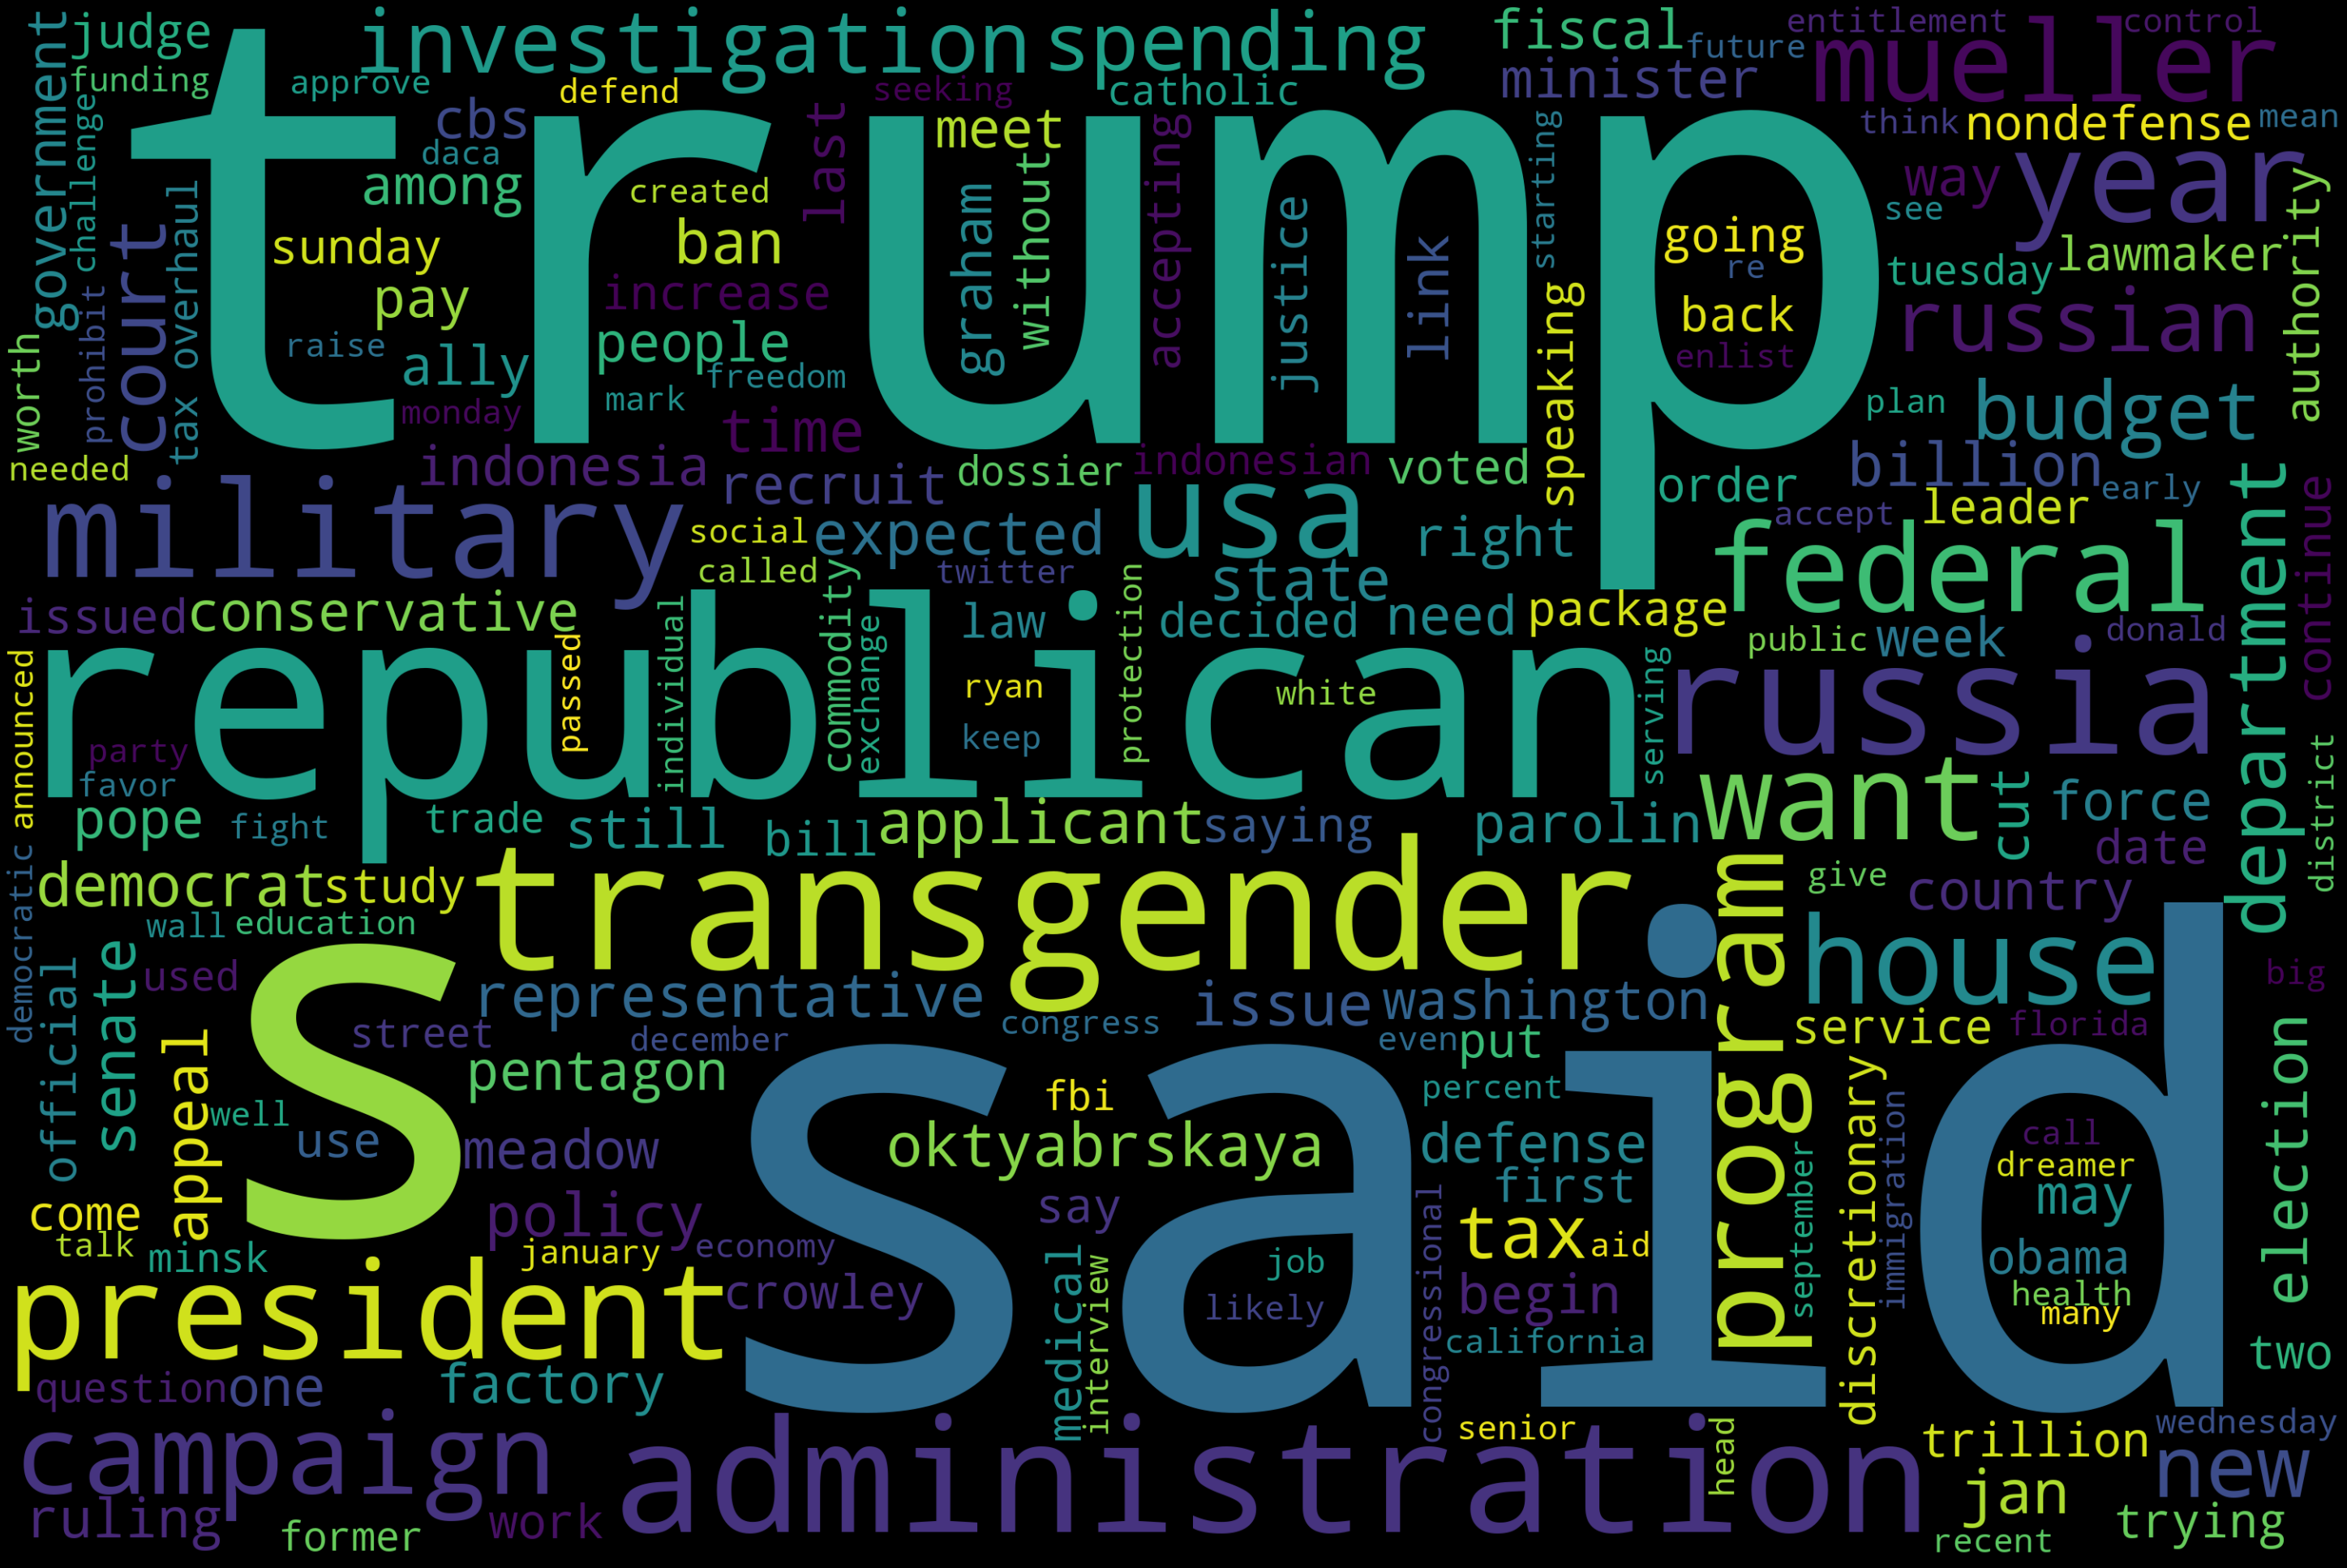

In [30]:
generate_word_cloud(data_cleaned[data_cleaned.is_fake == 0].article.values)

``Fake News WordCloud`` 

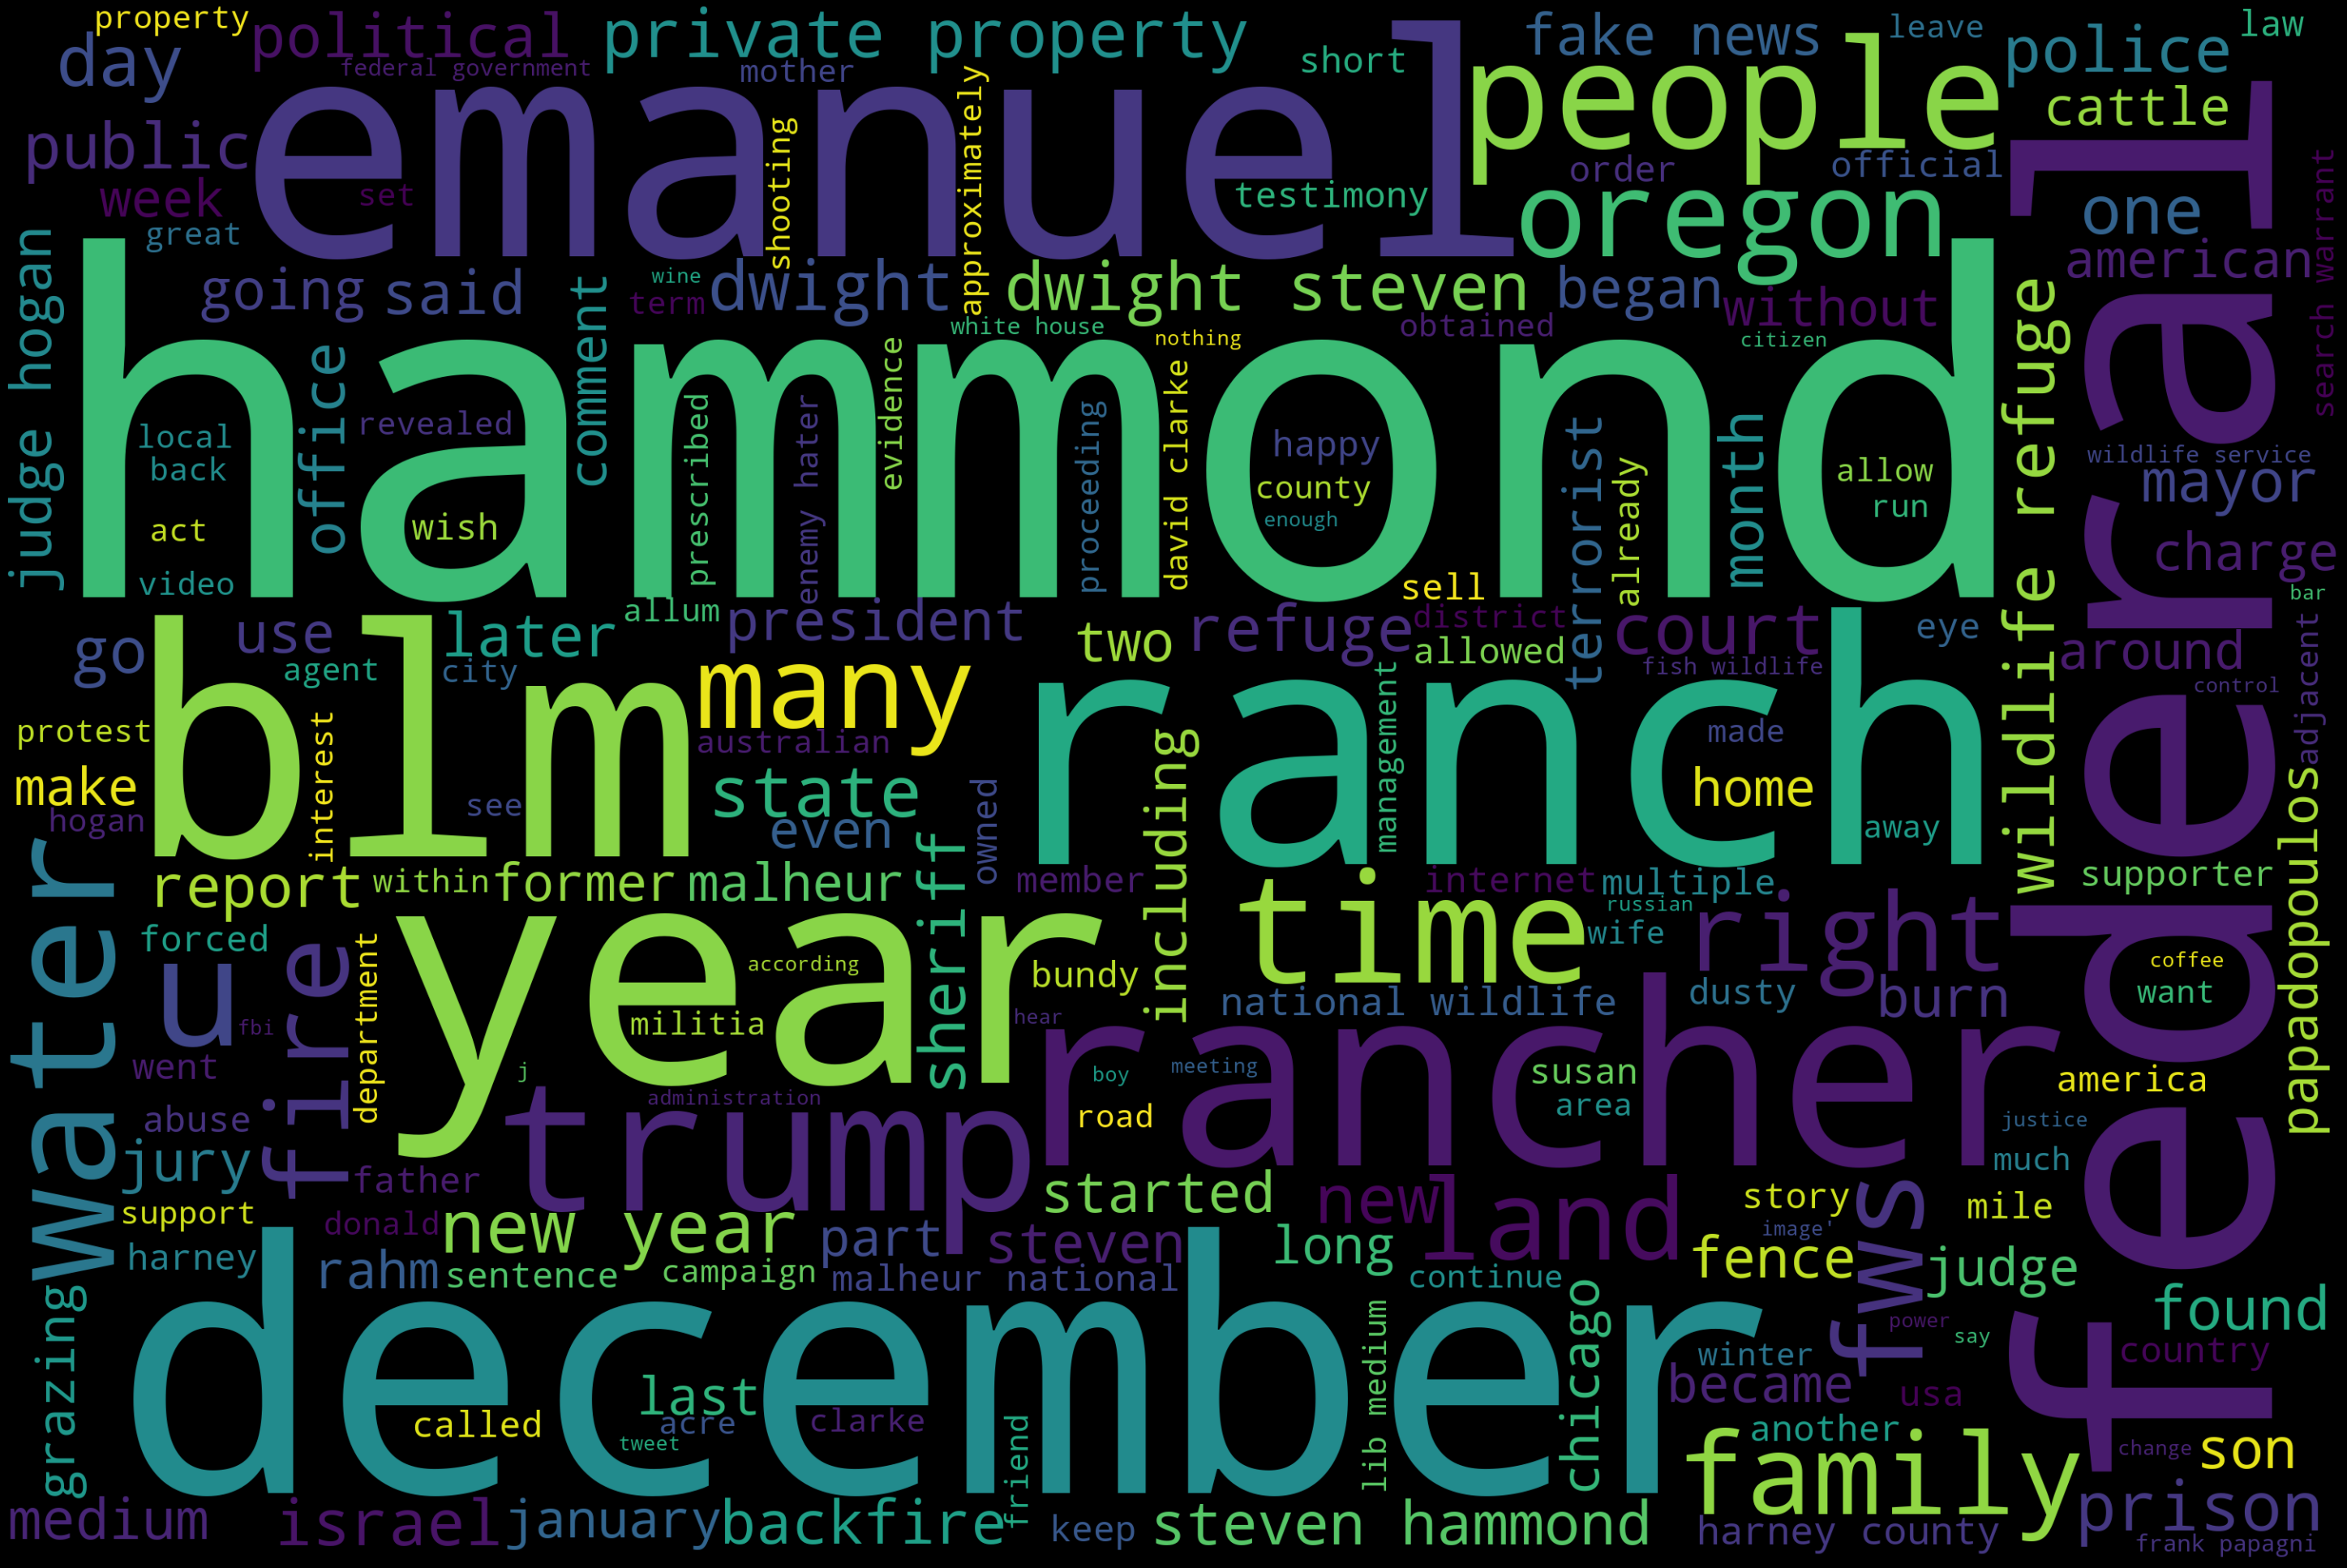

In [31]:
generate_word_cloud(data_cleaned[data_cleaned.is_fake == 1].article.values)

Now, we will visualize our article's length to determine the max length, especially for GloVe and BERT.

In [32]:
word_count = data_cleaned
word_count['word count'] = data_cleaned['article'].str.split().str.len()

fig = px.histogram(word_count, x="word count")
fig.show()

As we can see from the histogram, 250 as our word length is sufficient without sacrificing our model's robustness.

## Creating models

``Baseline Model``

In [33]:
print(20821/38265*100)

54.41264863452241


Since there sre 54.41% of real news, we can set our baseline model to 54.41%. If our model could pass this baseline model, it means that it has successfully learned to classify our dataset.

### TF-IDF

``Importing the required library``

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import classification_report

In [35]:
X_train, X_test, y_train, y_test = train_test_split(data_cleaned['article'], data_cleaned['is_fake'], test_size = 0.2, stratify = data_cleaned[['is_fake']], random_state = 100)

In [36]:
def get_prediction(vectorizer, classifier, X_train, X_test, y_train, y_test):
    pipe = Pipeline([('vector', vectorizer),
                    ('model', classifier)])
    model = pipe.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Accuracy: {}".format(round(accuracy_score(y_test, y_pred)*100,2)))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix: \n", cm)
    return float(accuracy_score(y_test, y_pred))
    
def final_prediction(vectorizer, classifier, X_train, X_test, y_train, y_test):
    pipe = Pipeline([('vector', vectorizer),
                    ('model', classifier)])
    model = pipe.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Accuracy: {}".format(round(accuracy_score(y_test, y_pred)*100,5)))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot = True, fmt=".0f", annot_kws={"size": 18})
    plt.show()
    print("Classification Report: \n", classification_report(y_test, y_pred))

#### SVM

Accuracy: 97.95
Confusion Matrix: 
 [[4113   51]
 [ 106 3383]]
Accuracy: 98.54
Confusion Matrix: 
 [[4128   36]
 [  76 3413]]
Accuracy: 98.65
Confusion Matrix: 
 [[4136   28]
 [  75 3414]]
Accuracy: 98.67
Confusion Matrix: 
 [[4136   28]
 [  74 3415]]
Accuracy: 98.64
Confusion Matrix: 
 [[4136   28]
 [  76 3413]]
--------------------------------------------------------------------------------------------
After trying several number of C possibilities, the fittest C parameter for this data is C = 1.0
Accuracy: 98.66719


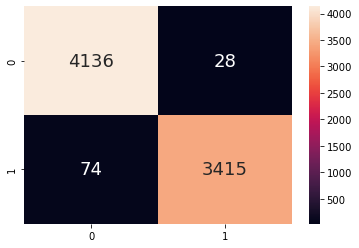

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      4164
           1       0.99      0.98      0.99      3489

    accuracy                           0.99      7653
   macro avg       0.99      0.99      0.99      7653
weighted avg       0.99      0.99      0.99      7653



In [37]:
accuracy = 0.0
tmp_accuracy = 0.0
best_c=0
c_list= [ 0.1,0.5,0.9, 1.0, 1.1]


for c in c_list :
  tmp_accuracy = get_prediction(TfidfVectorizer(), LinearSVC(C =c, random_state = 100), X_train, X_test, y_train, y_test)
  if tmp_accuracy > accuracy:
    accuracy = tmp_accuracy     
    best_c=c

print ("--------------------------------------------------------------------------------------------")
print("After trying several number of C possibilities, the fittest C parameter for this data is C =", best_c)
final_prediction(TfidfVectorizer(), LinearSVC(C =best_c), X_train, X_test, y_train, y_test)


#### Decision Tree

Accuracy: 92.98
Confusion Matrix: 
 [[3983  181]
 [ 356 3133]]
Accuracy: 93.4
Confusion Matrix: 
 [[3980  184]
 [ 321 3168]]
Accuracy: 93.53
Confusion Matrix: 
 [[3954  210]
 [ 285 3204]]
Accuracy: 93.35
Confusion Matrix: 
 [[3949  215]
 [ 294 3195]]
--------------------------------------------------------------------------------------------
After trying several number of depth possibilities, the fittest depth parameter for this data is depth = 50
Accuracy: 93.53195


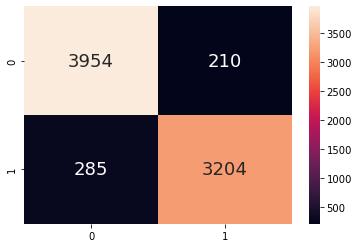

Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.95      0.94      4164
           1       0.94      0.92      0.93      3489

    accuracy                           0.94      7653
   macro avg       0.94      0.93      0.93      7653
weighted avg       0.94      0.94      0.94      7653



In [38]:
accuracy = 0
tmp_accuracy = 0
best_depth=0
depth_list= [10,30,50,100]


for depth in depth_list :
  tmp_accuracy = get_prediction(TfidfVectorizer(), DecisionTreeClassifier(max_depth = depth, random_state = 100), X_train, X_test, y_train, y_test)
  if tmp_accuracy > accuracy:
    accuracy=tmp_accuracy
    best_depth=depth

print ("--------------------------------------------------------------------------------------------")
print("After trying several number of depth possibilities, the fittest depth parameter for this data is depth =", best_depth)
final_prediction(TfidfVectorizer(), DecisionTreeClassifier(max_depth = best_depth, random_state = 100), X_train, X_test, y_train, y_test)

#### Random Forest

Accuracy: 96.62
Confusion Matrix: 
 [[4125   39]
 [ 220 3269]]
Accuracy: 96.68
Confusion Matrix: 
 [[4130   34]
 [ 220 3269]]
Accuracy: 96.75
Confusion Matrix: 
 [[4132   32]
 [ 217 3272]]
--------------------------------------------------------------------------------------------
After trying several number of trees possibilities, the fittest n_estimators parameter for this data is =  300
Accuracy: 96.74637


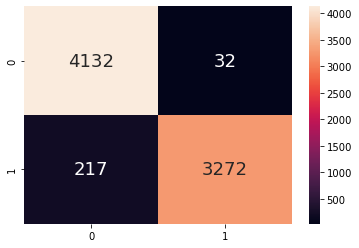

Classification Report: 
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      4164
           1       0.99      0.94      0.96      3489

    accuracy                           0.97      7653
   macro avg       0.97      0.97      0.97      7653
weighted avg       0.97      0.97      0.97      7653



In [39]:
accuracy = 0
tmp_accuracy = 0
best_n_tree=0
n_trees= [100,200,300]


for n_tree in n_trees :
  tmp_accuracy = get_prediction(TfidfVectorizer(), RandomForestClassifier(n_estimators = n_tree, max_depth = best_depth, random_state = 100), X_train, X_test, y_train, y_test)
  if tmp_accuracy > accuracy:
    accuracy=tmp_accuracy
    best_n_tree=n_tree

print ("--------------------------------------------------------------------------------------------")
print("After trying several number of trees possibilities, the fittest n_estimators parameter for this data is = ", best_n_tree)
final_prediction(TfidfVectorizer(), RandomForestClassifier(n_estimators = best_n_tree, max_depth = best_depth, random_state = 100), X_train, X_test, y_train, y_test)

#### XGBoost

/home/students/s121md106_09/anaconda3/envs/niko_project/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[16:08:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 98.41
Confusion Matrix: 
 [[4122   42]
 [  80 3409]]


/home/students/s121md106_09/anaconda3/envs/niko_project/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[16:08:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 98.41
Confusion Matrix: 
 [[4123   41]
 [  81 3408]]


/home/students/s121md106_09/anaconda3/envs/niko_project/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[16:09:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 98.45
Confusion Matrix: 
 [[4125   39]
 [  80 3409]]


/home/students/s121md106_09/anaconda3/envs/niko_project/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[16:10:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 98.41
Confusion Matrix: 
 [[4125   39]
 [  83 3406]]
--------------------------------------------------------------------------------------------
After trying several number of trees possibilities, the fittest n_estimators parameter for this data is = 500


/home/students/s121md106_09/anaconda3/envs/niko_project/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[16:11:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 98.44505


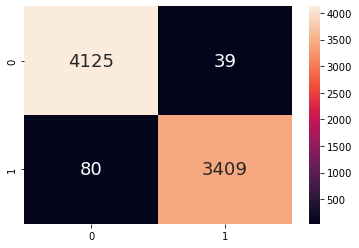

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      4164
           1       0.99      0.98      0.98      3489

    accuracy                           0.98      7653
   macro avg       0.98      0.98      0.98      7653
weighted avg       0.98      0.98      0.98      7653



In [40]:
accuracy = 0
tmp_accuracy = 0
best_n_tree=0
n_tree_list= [100, 200, 300, 500]


for n_tree in n_tree_list :
  tmp_accuracy = get_prediction(TfidfVectorizer(), XGBClassifier(max_depth = best_depth, n_estimators = n_tree, random_state = 100), X_train, X_test, y_train, y_test)
  if tmp_accuracy > accuracy:
    accuracy=tmp_accuracy
    best_n_tree=n_tree

print ("--------------------------------------------------------------------------------------------")
print("After trying several number of trees possibilities, the fittest n_estimators parameter for this data is =", n_tree)
final_prediction(TfidfVectorizer(), XGBClassifier(max_depth = best_depth, n_estimators = best_n_tree, random_state = 100), X_train, X_test, y_train, y_test)

Although in each of the model it seems that we only try on 4 values on the parameters, we have actually tried more than that, however, in order to save the running time we only put 4 different values on each parameters to show the contrast and that twitching the values will give us a better result.

### GloVe

An unsupervised learning algorithm used to obtain vector representation of words

``Importing the required library``

In [41]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout
from tensorflow.keras.preprocessing import text, sequence 
from tensorflow.keras.models import Sequential

2021-11-11 16:12:50.236640: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-11 16:12:50.236662: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [42]:
X_train, X_test, y_train, y_test = train_test_split(data_cleaned[['article']], data_cleaned[['is_fake']], test_size = 0.2, stratify = data_cleaned[['is_fake']], random_state = 100)

#### Tokenize + Padding

Tokenizer finds the frequency of each unique word and sort them based on their frequency. Then, it will assign an integer value (starting from 1) to each word from the top.

In [43]:
xtrain_values = X_train['article'].values
xtest_values = X_test['article'].values

In [44]:
max_len = 250

In [45]:
max_words = 10000
tokenizer = text.Tokenizer(num_words=max_words)

# Fit tokenizer on our training data set to create the word indices
tokenizer.fit_on_texts(xtrain_values)

# Using word index from fit_on_texts step, we transform both train & test data set
X_train_seq = tokenizer.texts_to_sequences(xtrain_values)
X_test_seq = tokenizer.texts_to_sequences(xtest_values)

# Add padding to the sequence
X_train_pad = sequence.pad_sequences(X_train_seq, maxlen = max_len)
X_test_pad = sequence.pad_sequences(X_test_seq, maxlen = max_len)
word_index = tokenizer.word_index


In [46]:
print("Text example:", xtrain_values[0])
print("Sequence of indices (before add padding): ", X_train_seq[0])
print("Sequence of indices (after add padding): ", X_train_pad[0])

Text example: denmark ramp cyber security effort defense ministerdenmark intends invest boost effort prevent cyber attack strategy presented early next year defense minister said tuesday going spend money area claus hjort frederiksen told reuters sideline conference copenhagen though declined disclose figure cyber security high agenda rightleaning government also broad selection danish political party negotiating new defense strategy coming six year said government would like expand early warning system sensor detects danish company authority attack example malware degree system today would like expand strategic infrastructure private company told reuters government also want increase preventive capacity danish center cyber security increase ability better catch inform imminent cyber threat said world container shipper one denmark largest company maersk hit major cyber attack june one biggestever disruption hit global shipping government also work deeper cooperation authority private c

#### Word Embedding using pre-trained GloVe vectors

Represent words with similar meaning to have similar representation

(GloVe pre-trained word vectors via: https://nlp.stanford.edu/projects/glove/)


Load the GloVe vectors

In [47]:
glovetxt = os.path.join(path, 'glove.6B.100d.txt')

In [48]:
embedding_vectors = {};

with open(glovetxt) as f:
    for line in f:
        values = line.split();
        word = values[0];
        weights = np.asarray(values[1:], dtype='float32');
        embedding_vectors[word] = weights;


In [49]:
print("Size of vocabulary in GloVe", len(embedding_vectors))

Size of vocabulary in GloVe 400000


**Embedding matrix with the GloVe vectors**

Embedding matrix with a shape of (vocab length, embedding dimension)

Each row of the matrix belongs to one word in the vocabulary and contains the weight of embedding vectors of the word

In [50]:
embedding_dim = 100   # size of the vector space in which words will be embedded
if max_words is not None: 
    vocab_len = max_words 
else:
    vocab_len = len(word_index)+1

# Initialize the embedding matrix with zeros
embedding_matrix = np.zeros((vocab_len, embedding_dim))

In [51]:
oov_count = 0
oov_words = []

for word, i in word_index.items():
  if i<vocab_len:
    embedding_vector = embedding_vectors.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector
    # If a word in word_index is not found in the embedding_vectors from GloVe, we put it in oov_words and its weight remains 0
    else:
      oov_count+=1
      oov_words.append(word)

In [52]:
print("Some Out of Vocabulary words: ", oov_words[0:10])

Some Out of Vocabulary words:  ['trump’s', '“i', '“the', '“we', 'obama’s', 'realdonaldtrump', 'brexit', 'it’s', 'don’t', 'presidentelect']


In [53]:
print(f"{oov_count} out of {vocab_len} words are OOV")

584 out of 10000 words are OOV


#### Modeling

##### **Model Architecture**

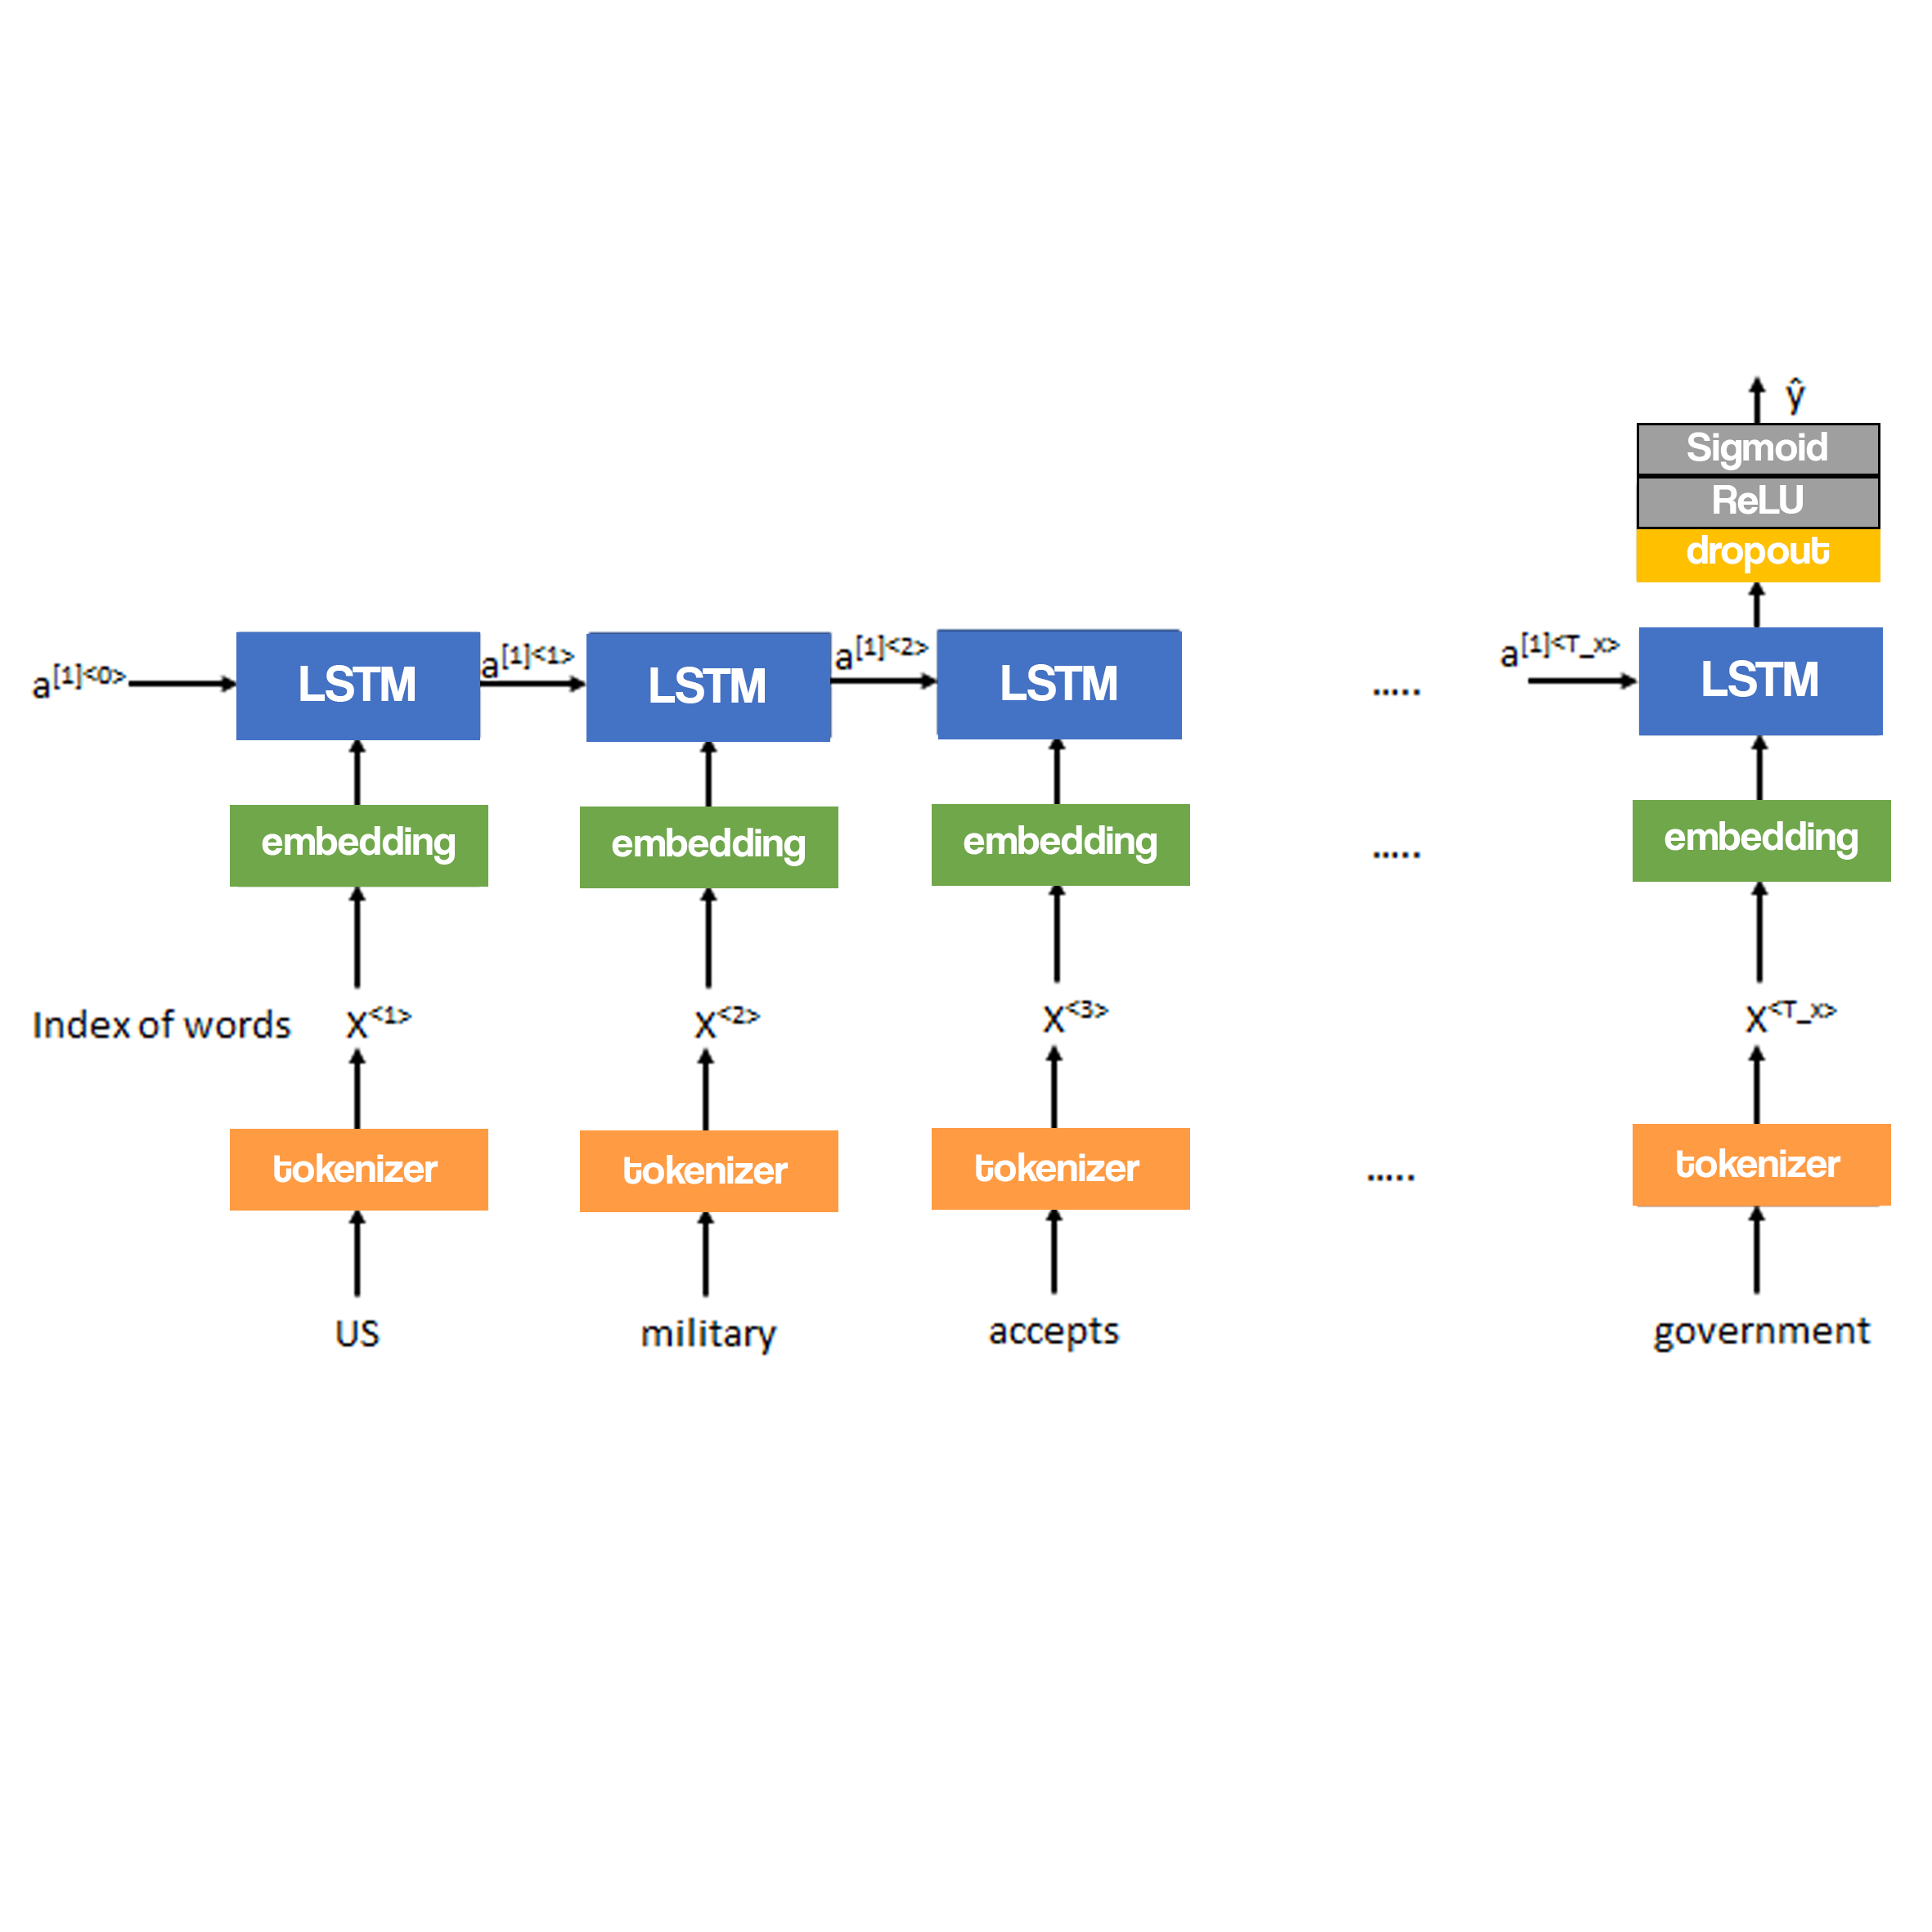

**First Layer: Embedding Layer**

It represents words using a dense vector representation. The position of a word within the vector space is based on the words that surround the word when it is used. E.g “king” is placed near “man”

In this case, we set the `weights` of the Embedding layer with embedding matrix from GloVe pre-trained vectors <br>We set the parameter `trainable` to False as we don't want the embedding weights to be updated

**Second Layer: LSTM**

Here we will use 3 different unit sizes, whicha re 64, 128, and 256. 
<br>The `return_sequences` set to be False as we don't want the output of previous LSTM layers to be used as the input in the next LSTM layers



**Third Layer: Dropout**

It is a regularizer technique that keeping it as away as possible from any bias (overfitting) by dropping out neurons at random, during every epoch
<br>Fraction of the input `unit` to drop: 0.5

**Final Layer: Dense**

It helps in changing the dimensionality of the output from the preceding layer so that the model can easily define the relationship between the values of the data in which the model is working.

We first use the ReLU (Rectified Linear Unit) activation function. The function returns 0 if it receives any negative input, but for any positive value  x  it returns that value back. So it can be written as  f(x)=max(0,x). The rectified linear activation function overcomes the vanishing gradient problem, allowing models to learn faster and perform better.

Since we are doing a Binary Classification in this case, the `activation` function is **sigmoid(x) = 1 / (1 + exp(-x))**. <br>Sigmoid function maps any input to an output ranging from **0 to 1** 
Sigmoid layer `unit` equals to 1 as the output size of the final layer


##### **LSTM with output size of 64**

In [54]:
lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_len, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=True),
    tf.keras.layers.LSTM(64,return_sequences=False),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm_model.summary())

2021-11-11 16:13:11.409401: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-11 16:13:11.409483: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-11-11 16:13:11.409543: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-11-11 16:13:11.409601: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2021-11-11 16:13:11.409658: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,044,353
Trainable params: 1,044,353
Non-trainable params: 0
_________________________________________________________________
None


Fit the model to the training and testing dataset

In [55]:
epochs  = 20
history = lstm_model.fit(X_train_pad, np.asarray(y_train), epochs = epochs, validation_data=(X_test_pad, np.asarray(y_test)), batch_size=128)

Epoch 1/20
240/240 [==============================] - 44s 179ms/step - loss: 0.2802 - accuracy: 0.8885 - val_loss: 0.1411 - val_accuracy: 0.9507
Epoch 2/20
240/240 [==============================] - 42s 177ms/step - loss: 0.1139 - accuracy: 0.9608 - val_loss: 0.0840 - val_accuracy: 0.9724
Epoch 3/20
240/240 [==============================] - 42s 176ms/step - loss: 0.0785 - accuracy: 0.9748 - val_loss: 0.0602 - val_accuracy: 0.9801
Epoch 4/20
240/240 [==============================] - 42s 176ms/step - loss: 0.0414 - accuracy: 0.9877 - val_loss: 0.0471 - val_accuracy: 0.9850
Epoch 5/20
240/240 [==============================] - 43s 177ms/step - loss: 0.0409 - accuracy: 0.9865 - val_loss: 0.0528 - val_accuracy: 0.9833
Epoch 6/20
240/240 [==============================] - 42s 176ms/step - loss: 0.0203 - accuracy: 0.9940 - val_loss: 0.0453 - val_accuracy: 0.9860
Epoch 7/20
240/240 [==============================] - 42s 177ms/step - loss: 0.0132 - accuracy: 0.9961 - val_loss: 0.0463 - val_ac

Evaluation of LSTM Model

Text(0.5, 1.0, 'Loss')

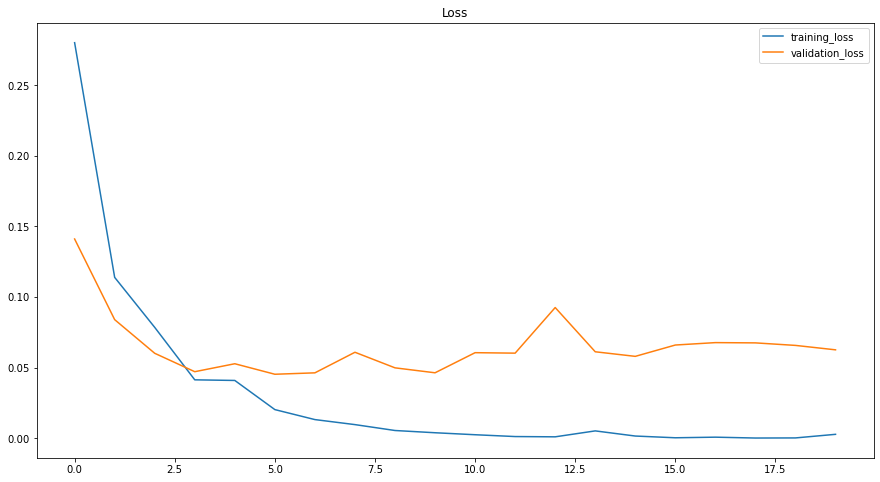

In [56]:
plt.figure(figsize = (15,8))
plt.plot(range(epochs), history.history['loss'])
plt.plot(range(epochs), history.history['val_loss'])
plt.legend(['training_loss', 'validation_loss'])
plt.title('Loss')

In [57]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=("Training Accuracy", "Test Accuracy"))

fig.add_trace(go.Scatter(x=[*range(epochs)], y=history.history['accuracy']), row=1, col=1)

fig.add_trace(go.Scatter(x=[*range(epochs)], y=history.history['val_accuracy']), row=2, col=1)

fig.show()


In [58]:
train_lstm_results = lstm_model.evaluate(X_train_pad, np.asarray(y_train), verbose=0, batch_size=256)
test_lstm_results = lstm_model.evaluate(X_test_pad, np.asarray(y_test), verbose=0, batch_size=256)
print(f'Train accuracy: {train_lstm_results[1]*100:0.2f}')
print(f'Test accuracy: {test_lstm_results[1]*100:0.2f}')

Train accuracy: 100.00
Test accuracy: 98.89


<AxesSubplot:>

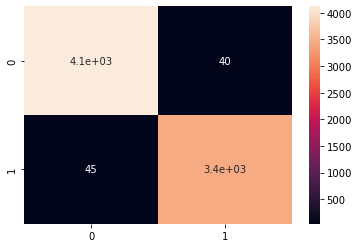

In [59]:
preds = lstm_model.predict(X_test_pad)

preds_flatten = preds.flatten()
preds_np = [1 if x > 0.5 else 0 for x in preds_flatten]

cm = confusion_matrix(preds_np, y_test)

sns.heatmap(cm, annot = True)

##### **LSTM with output size of 128**

In [60]:
lstm2_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_len, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=True),
    tf.keras.layers.LSTM(128,return_sequences=False),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

lstm2_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm2_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 100)          1000000   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,121,409
Trainable params: 1,121,409
Non-trainable params: 0
_________________________________________________________________
None


In [61]:
epochs  = 20
history = lstm2_model.fit(X_train_pad, np.asarray(y_train), epochs = epochs, validation_data=(X_test_pad, np.asarray(y_test)), batch_size=128)

Epoch 1/20
240/240 [==============================] - 79s 323ms/step - loss: 0.2279 - accuracy: 0.9132 - val_loss: 0.1163 - val_accuracy: 0.9592
Epoch 2/20
240/240 [==============================] - 77s 321ms/step - loss: 0.0859 - accuracy: 0.9724 - val_loss: 0.0811 - val_accuracy: 0.9745
Epoch 3/20
240/240 [==============================] - 77s 322ms/step - loss: 0.0612 - accuracy: 0.9825 - val_loss: 0.0535 - val_accuracy: 0.9828
Epoch 4/20
240/240 [==============================] - 77s 321ms/step - loss: 0.0442 - accuracy: 0.9854 - val_loss: 0.0578 - val_accuracy: 0.9821
Epoch 5/20
240/240 [==============================] - 77s 321ms/step - loss: 0.0232 - accuracy: 0.9933 - val_loss: 0.0313 - val_accuracy: 0.9907
Epoch 6/20
240/240 [==============================] - 77s 321ms/step - loss: 0.0131 - accuracy: 0.9962 - val_loss: 0.0409 - val_accuracy: 0.9875
Epoch 7/20
240/240 [==============================] - 77s 321ms/step - loss: 0.0107 - accuracy: 0.9966 - val_loss: 0.0456 - val_ac

Text(0.5, 1.0, 'Loss')

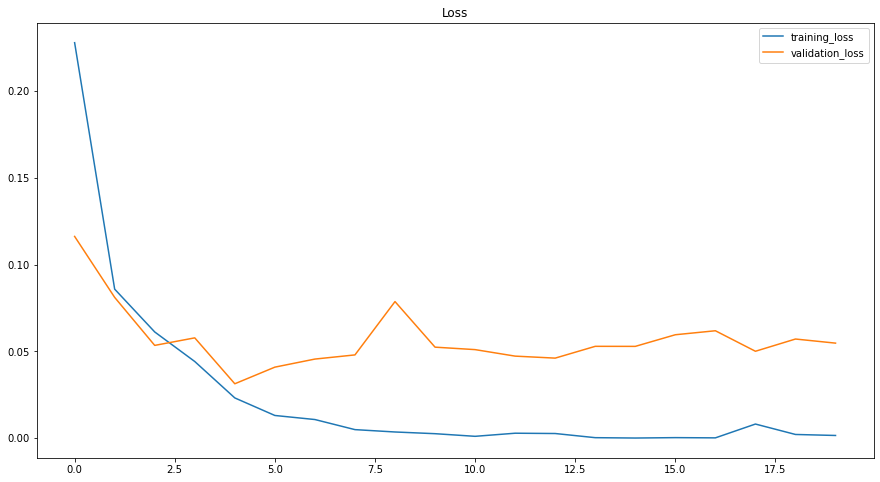

In [62]:
plt.figure(figsize = (15,8))
plt.plot(range(epochs), history.history['loss'])
plt.plot(range(epochs), history.history['val_loss'])
plt.legend(['training_loss', 'validation_loss'])
plt.title('Loss')

In [63]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=("Training Accuracy", "Test Accuracy"))

fig.add_trace(go.Scatter(x=[*range(epochs)], y=history.history['accuracy']), row=1, col=1)

fig.add_trace(go.Scatter(x=[*range(epochs)], y=history.history['val_accuracy']), row=2, col=1)

fig.show()

In [64]:
train_lstm2_results = lstm2_model.evaluate(X_train_pad, np.asarray(y_train), verbose=0, batch_size=256)
test_lstm2_results = lstm2_model.evaluate(X_test_pad, np.asarray(y_test), verbose=0, batch_size=256)
print(f'Train accuracy: {train_lstm2_results[1]*100:0.3f}')
print(f'Test accuracy: {test_lstm2_results[1]*100:0.3f}')

Train accuracy: 99.980
Test accuracy: 99.020


<AxesSubplot:>

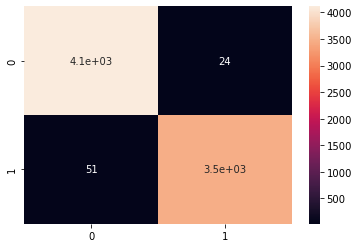

In [65]:
preds = lstm2_model.predict(X_test_pad)
preds_flatten = preds.flatten()
preds_np = [1 if x > 0.5 else 0 for x in preds_flatten]

cm = confusion_matrix(preds_np, y_test)

sns.heatmap(cm, annot = True)

##### **LSTM with output size of 256**

In [66]:
lstm3_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_len, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=True),
    tf.keras.layers.LSTM(256,return_sequences=False),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

lstm3_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm3_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 250, 100)          1000000   
                                                                 
 lstm_2 (LSTM)               (None, 256)               365568    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 32)                8224      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,373,825
Trainable params: 1,373,825
Non-trainable params: 0
_________________________________________________________________
None


In [67]:
epochs  = 20
history = lstm3_model.fit(X_train_pad, np.asarray(y_train), epochs = epochs, validation_data=(X_test_pad, np.asarray(y_test)), batch_size=128)

Epoch 1/20
240/240 [==============================] - 150s 619ms/step - loss: 0.2016 - accuracy: 0.9230 - val_loss: 0.1287 - val_accuracy: 0.9566
Epoch 2/20
240/240 [==============================] - 148s 616ms/step - loss: 0.1184 - accuracy: 0.9581 - val_loss: 0.0773 - val_accuracy: 0.9715
Epoch 3/20
240/240 [==============================] - 148s 615ms/step - loss: 0.0502 - accuracy: 0.9838 - val_loss: 0.1169 - val_accuracy: 0.9624
Epoch 4/20
240/240 [==============================] - 148s 616ms/step - loss: 0.0296 - accuracy: 0.9913 - val_loss: 0.0345 - val_accuracy: 0.9890
Epoch 5/20
240/240 [==============================] - 148s 615ms/step - loss: 0.0187 - accuracy: 0.9943 - val_loss: 0.0333 - val_accuracy: 0.9889
Epoch 6/20
240/240 [==============================] - 148s 616ms/step - loss: 0.0082 - accuracy: 0.9975 - val_loss: 0.0350 - val_accuracy: 0.9893
Epoch 7/20
240/240 [==============================] - 147s 613ms/step - loss: 0.0044 - accuracy: 0.9989 - val_loss: 0.0432 -

Text(0.5, 1.0, 'Loss')

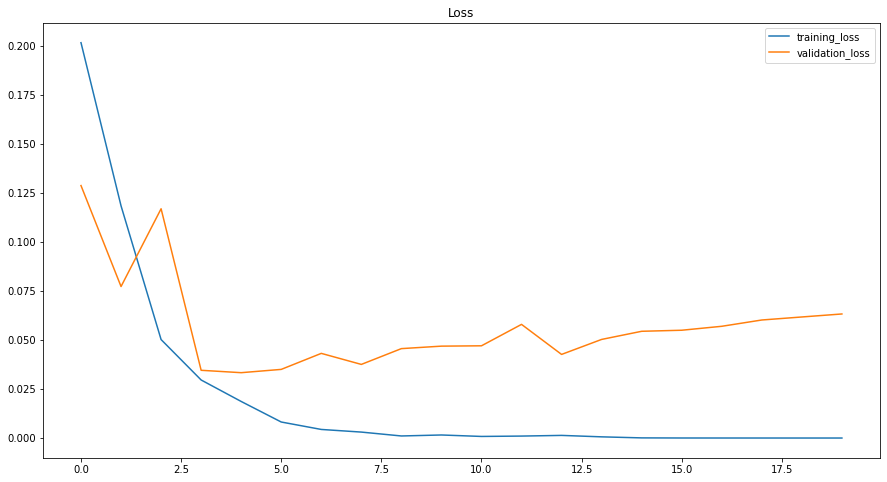

In [68]:
plt.figure(figsize = (15,8))
plt.plot(range(epochs), history.history['loss'])
plt.plot(range(epochs), history.history['val_loss'])
plt.legend(['training_loss', 'validation_loss'])
plt.title('Loss')

In [69]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=("Training Accuracy", "Test Accuracy"))

fig.add_trace(go.Scatter(x=[*range(epochs)], y=history.history['accuracy']), row=1, col=1)

fig.add_trace(go.Scatter(x=[*range(epochs)], y=history.history['val_accuracy']), row=2, col=1)

fig.show()


In [70]:
train_lstm3_results = lstm2_model.evaluate(X_train_pad, np.asarray(y_train), verbose=0, batch_size=256)
test_lstm3_results = lstm2_model.evaluate(X_test_pad, np.asarray(y_test), verbose=0, batch_size=256)
print(f'Train accuracy: {train_lstm3_results[1]*100:0.3f}')
print(f'Test accuracy: {test_lstm3_results[1]*100:0.3f}')

Train accuracy: 99.980
Test accuracy: 99.020


<AxesSubplot:>

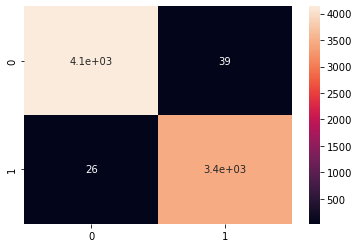

In [71]:
preds = lstm3_model.predict(X_test_pad)
preds_flatten = preds.flatten()
preds_np = [1 if x > 0.5 else 0 for x in preds_flatten]
cm = confusion_matrix(preds_np, y_test)
sns.heatmap(cm, annot = True)


### BERT

In [72]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [73]:
import torch
torch.cuda.set_device(0)
torch.cuda.current_device()

0

In [74]:
!nvidia-smi

Thu Nov 11 17:44:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:05:00.0 Off |                  N/A |
| 23%   34C    P8     9W / 250W |   3677MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:06:00.0 Off |                  N/A |
| 23%   32C    P8     9W / 250W |   1755MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [75]:
from datasets import Dataset

In [76]:
# Show function

# Use this to display your dataset!
from datasets import ClassLabel, Sequence
from IPython.display import display, HTML
from random import randint
def show_elements(dataset, randomize = True, num_samples = 10):
    if isinstance(dataset,pd.DataFrame):                  
        if randomize:                                          
            dataset = dataset.sample(frac=1)
        display(HTML(dataset.iloc[:num_samples].to_html()))            
    else:                                                    
        if randomize:                                          
            dataset = dataset.shuffle(seed = randint(1,100))   
        dataset = pd.DataFrame(dataset.select(range(num_samples)))   
        display(HTML(dataset.to_html()))

In [77]:
data_cleaned = pd.read_csv(os.path.join(path, 'data_cleaned.csv'))
data_cleaned.dropna(inplace=True)
data_cleaned.head() # This data still contains the unrequired features

title  \
0  As U.S.A. budget fight looms, Republicans flip...   
1  U.S.A. military to accept transgender recruits...   
2  Senior U.S.A. Republican senator: 'Let Mr. Mue...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text  is_fake  \
0  The head of a conservative Republican faction ...        0   
1  Transgender people will be allowed for the fir...        0   
2  The special counsel investigation of links bet...        0   
3  Trump campaign adviser George Papadopoulos tol...        0   
4  President Donald Trump called on the U.S.A. Po...        0   

                                             article  
0  usa budget fight loom republican flip fiscal s...  
1  usa military accept transgender recruit monday...  
2  senior usa republican senator let mr mueller j...  
3  fbi russia probe helped australian diplomat ti...  
4  trump want postal service charge much amazon s...

In [78]:
# Thus, we take only the required columns
df = pd.DataFrame(data_cleaned[['article', 'is_fake']])

df.columns = ['article', 'label'] # we change the column names


In [79]:
huggingface_dataset = Dataset.from_pandas(df)
huggingface_dataset = huggingface_dataset.remove_columns("__index_level_0__")

show_elements(huggingface_dataset, randomize = True, num_samples = 3)

In [80]:
huggingface_dataset = huggingface_dataset.train_test_split(test_size = 0.2, 
                                                           shuffle = True, 
                                                           seed = 0)
huggingface_dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'label'],
        num_rows: 30612
    })
    test: Dataset({
        features: ['article', 'label'],
        num_rows: 7653
    })
})

#### Choose your Transformers model
- Huggingface model repository: https://huggingface.co/models?sort=downloads

In [81]:
# Get the exact name of the model you want 
model_checkpoint = "distilbert-base-uncased"

#### AutoModelForSequenceClassification
- AutoModelForSequenceClassification loads the correct model architecture for classifying sentences
- AutoModelForSequenceClassification documentation: https://huggingface.co/transformers/model_doc/auto.html#automodelforsequenceclassification

In [82]:
from transformers import AutoModelForSequenceClassification

In [83]:
# from_pretrained() method loads the model
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, 
                                                           num_labels=2)     
model       # we have 2 labels: 1 and 0

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

#### AutoTokenizer
- AutoTokenizer loads the right tokenizer for your model
- AutoTokenizer documentation: https://huggingface.co/transformers/model_doc/auto.html#autotokenizer

In [84]:
from transformers import AutoTokenizer

In [85]:
# from_pretrained() method loads the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

#### Tokenize your Dataset
- You need to convert your raw input text into the correct input format that BERT expects!
  - input_ids - a sequence of indices where each index corresponds to a particular token
  - attention_mask - tells BERT not to focus on padding tokens
  - label - encoded target variable
- tokenizer documentation: https://huggingface.co/transformers/internal/tokenization_utils.html

In [86]:
# define your preprocessing function
def preprocess(examples):
    tokenized_examples = tokenizer(examples['article'], 
                                   padding = "max_length",
                                   truncation = True,
                                   max_length = 250)
    return tokenized_examples

In [87]:
# use the map() function to preprocess the whole Dataset
tokenized_dataset = huggingface_dataset.map(preprocess, 
                                            batched = True, 
                                            batch_size = 32,
                                            remove_columns = ["article"])
tokenized_dataset

  0%|          | 0/957 [00:00<?, ?ba/s]

  0%|          | 0/240 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'label'],
        num_rows: 30612
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'label'],
        num_rows: 7653
    })
})

In [88]:
# this table shows the inout format that BERT expects!
show_elements(tokenized_dataset["train"],randomize = False, num_samples = 5)

#### TrainingArguments
- TrainingArguments allow us to set training configurations.
- The more important arguments are:
  - evaluation_strategy - determines when to evaluate your model on the test set 
  - learning_rate - determines how fast your model updates its parameters
  - num_train_epochs - determines number of epochs to train your model
- TrainingArguments documentation: https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments

In [89]:
from transformers import TrainingArguments

In [90]:
args = TrainingArguments(
    "fake_news_datasets_checkpoint",
    evaluation_strategy = "epoch",                           
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,                              
    metric_for_best_model="accuracy",
    logging_steps = 800,
    save_strategy = "epoch",
)

#### load_metric
- You can load available metrics to evaluate you model here: https://huggingface.co/metrics
- source: https://huggingface.co/docs/datasets/package_reference/loading_methods.html 

In [91]:
import numpy as np
from datasets import load_metric
import seaborn as sns
import matplotlib.pyplot as plt

In [92]:
metric = load_metric("accuracy")
from sklearn.metrics import confusion_matrix

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    confusion_matrix(labels, predictions)
    sns.heatmap(confusion_matrix(labels, predictions), annot=True)
    
    return metric.compute(predictions=predictions, references=labels)

#### Trainer
- Trainer ties together to all the components above and initiates training using .train() method
- https://huggingface.co/transformers/main_classes/trainer.html#id1

In [93]:
from transformers import Trainer

In [94]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_dataset["train"],                  
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics
)

***** Running training *****
  Num examples = 30612
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 1
  Total optimization steps = 720
/home/students/s121md106_09/anaconda3/envs/niko_project/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.



***** Running Evaluation *****
  Num examples = 7653
  Batch size = 128
Saving model checkpoint to fake_news_datasets_checkpoint/checkpoint-240
Configuration saved in fake_news_datasets_checkpoint/checkpoint-240/config.json
Model weights saved in fake_news_datasets_checkpoint/checkpoint-240/pytorch_model.bin
/home/students/s121md106_09/anaconda3/envs/niko_project/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.

***** Running Evaluation *****
  Num examples = 7653
  Batch size = 128
Saving model checkpoint to fake_news_datasets_checkpoint/checkpoint-480
Configuration saved in fake_news_datasets_checkpoint/checkpoint-480/config.json
Model weights saved in fake_news_datasets_checkpoint/checkpoint-480/pytorch_model.bin
/home/students/s121md106_09/anaconda3/envs/niko_project/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWa

TrainOutput(global_step=720, training_loss=0.028460401958889433, metrics={'train_runtime': 387.6719, 'train_samples_per_second': 236.891, 'train_steps_per_second': 1.857, 'total_flos': 5940076183092000.0, 'train_loss': 0.028460401958889433, 'epoch': 3.0})

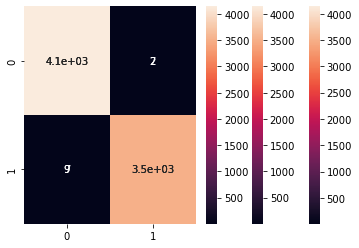

In [95]:
trainer.train()

***** Running Evaluation *****
  Num examples = 7653
  Batch size = 128
/home/students/s121md106_09/anaconda3/envs/niko_project/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:68: UserWarning:

Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.



{'eval_loss': 0.007098643574863672,
 'eval_accuracy': 0.998562655167908,
 'eval_runtime': 11.3819,
 'eval_samples_per_second': 672.385,
 'eval_steps_per_second': 5.272,
 'epoch': 3.0}

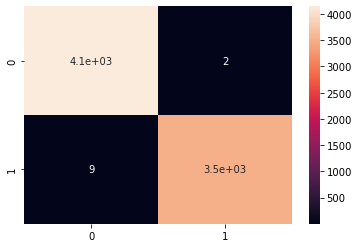

In [96]:
trainer.evaluate()